In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler

In [2]:
# Pega o DF, dropa as colunas que não iremos utilizar e faz a media para as categorias que são cabiveis de tal ação.
def DADOS(url:str,n_rodadas):
    df = pd.read_csv(url,sep = ';')
    df = df.drop(['VCasa',"ECasa","DCasa","GPCasa","GCCasa",
                  "PtCasa","VFora","EFora","DFora","GPFora",
                  "GCFora","PtFora"],axis=1)
    df.iloc[:,4:37]=df.iloc[:,4:37]/n_rodadas
    df.iloc[:,2]=df.iloc[:,2]/10
    return df

In [3]:
df19 = DADOS('.\Dados\dados2019.csv',38)

In [4]:
#Transforma os dados em uma escala os dados entre 0 e 1
scaler = MaxAbsScaler().fit(df19.iloc[:,1:37])
a = scaler.transform(df19.iloc[:,1:37])
df191 = df19
df191.iloc[:,1:37]=a

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

#Seleciona as colunas mais importantes
def reduzir(df,coluna,theta):
    model = RandomForestRegressor(random_state=1, max_depth=10)
    model.fit(a,df.loc[:,coluna])
    features = df.columns[1:37]
    importances = model.feature_importances_
    indices = np.argsort(importances) #[0:9])  # top 10 features
    plt.figure(figsize=(12,10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.xmin = [0.01]
    plt.show()
    new_model = SelectFromModel(model,threshold=theta)
    fit = new_model.fit_transform(a, df.loc[:,coluna])
    new_model.get_support()
    selected_columns = np.array(df.columns[1:37])[new_model.get_support()]
    df3 = df[selected_columns]
    pd.options.mode.chained_assignment = None
    df3[coluna] = df[coluna]
    return df3

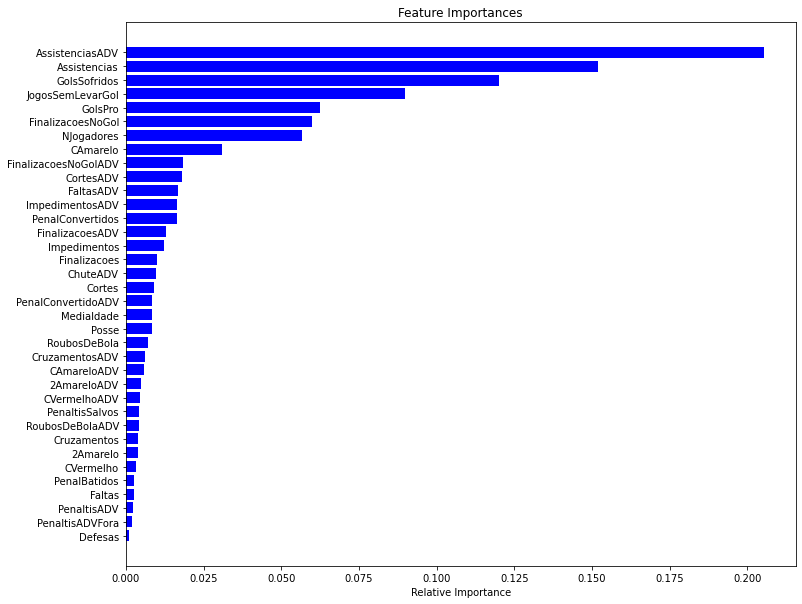

In [40]:
#Selecionar colunas de Pontos
df3 = reduzir(df191,'Pt',0.05)

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression , Lasso, Ridge, RidgeCV, ElasticNet, HuberRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

#Testa diversos modelos e verifica seus resultados
def print_models(X,Y):
    validation_size = 0.20
    seed = 0
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
    num_folds = 5
    score = 'r2'
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('LASSO', Lasso(random_state=seed)))
    models.append(('EN', ElasticNet(random_state=seed)))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('CART', DecisionTreeRegressor(random_state=seed)))
    models.append(('SVR', SVR()))
    models.append(('RIDGE', Ridge(random_state=seed)))
    models.append(('RIDGECV', RidgeCV()))
    #models.append(('MLPR', MLPRegressor(random_state=seed, max_iter = 20000)))
    models.append(('GPR', GaussianProcessRegressor(random_state=seed)))
    models.append(('AB', AdaBoostRegressor(random_state=seed)))
    models.append(('RF', RandomForestRegressor(random_state=seed)))
    models.append(('ET', ExtraTreesRegressor(random_state=seed)))
    models.append(('GBM', GradientBoostingRegressor(random_state=seed)))
    models.append(('HRE', HuberRegressor(max_iter = 2000)))
    models.append(('BRI' , BayesianRidge(n_iter = 2000)))
    
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [42]:
#Dados e Target
X = df3.values[:,0:-1]
Y = df3.values[:,-1]

In [43]:
print_models(X,Y)

LR: -1.415543 (2.793681)
LASSO: 0.218411 (0.469953)
EN: -0.160828 (0.365371)
KNN: 0.532834 (0.157320)
CART: -0.136817 (1.261223)
SVR: -0.126538 (0.312721)
RIDGE: 0.391433 (0.293554)
RIDGECV: 0.546085 (0.278075)
GPR: -1.121309 (1.919344)
AB: 0.403949 (0.263566)
RF: 0.519568 (0.256330)
ET: 0.545432 (0.413032)
GBM: 0.192491 (0.360214)
HRE: -0.894129 (1.847917)
BRI: 0.452594 (0.375708)


### RIDGE is somewhat? the BEST!!!

In [44]:
#Treinando o modelo
#Pontos = Ridge(random_state=0).fit(X,Y)
#Pontos = RandomForestRegressor(random_state=0).fit(X,Y)
#Pontos = AdaBoostRegressor(random_state=0).fit(X,Y)
Pontos = BayesianRidge(n_iter = 2000).fit(X,Y)
#Pontos = RidgeCV().fit(X,Y)

In [45]:
#Carregando os dados de 2020, onde testaremos o modelo
df20 = DADOS('.\Dados\dados2020.csv',38)
df20.iloc[:,1:37] = scaler.transform(df20.iloc[:,1:37])
i = df20[df3.columns]
prev = np.around(Pontos.predict(i.values[:,0:-1]),0)

In [46]:
#Tabela de 2020 com Previsão e Pontos Reais
r = pd.DataFrame()
r['e']= df20.Equipe
r['pts'] = i.Pt
r['ptsprev']= prev
r['Erro']=abs(r['pts']-r['ptsprev'])
r=r.sort_values('ptsprev', ascending=False)
#r.sort_values('Erro', ascending=False)
#r.sum() = 78 ( BayesianRidge )   81 (RidgeCV)
r

,e,pts,ptsprev,Erro
6,Chapecoense,73,68.0,5.0
9,Cuiabá,61,62.0,1.0
0,América (MG),73,60.0,13.0
12,Juventude,61,60.0,1.0
15,Operário,57,56.0,1.0
18,Sampaio Corrêa,57,55.0,2.0
8,Cruzeiro,49,55.0,6.0
5,CSA,58,52.0,6.0
4,CRB,52,50.0,2.0
13,Náutico,44,49.0,5.0


In [38]:
#Importando Dados de 2021, Validação*?* do modelo
df21 = DADOS('.\Dados\\ate33.csv',38)
df21.iloc[:,1:37] = scaler.transform(df21.iloc[:,1:37])
i = df21[df3.columns]
prev = np.around(Pontos.predict(i.values[:,0:-1]),0)

In [39]:
#Tabela de 2021 com Previsão e Pontos Reais
r = pd.DataFrame()
r['e']= df21.Equipe
r['ptsprev']= prev
r['pts'] = i.Pt
r=r.sort_values('pts', ascending=False)
r['Po.']=range(1,21)
r=r.sort_values('ptsprev', ascending=False)
r['Po. Prev.']=range(1,21)
r['Erro']=abs(r['pts']-r['ptsprev'])
r=r.sort_values('ptsprev', ascending=False)
r
#r.sum() = 111/76 com BayesianRidge

,e,ptsprev,pts,Po.,Po. Prev.,Erro
1,Botafogo (RJ),63.0,59,2,1,4.0
7,Coritiba,60.0,61,1,2,1.0
10,Guarani,60.0,52,6,3,8.0
0,Avaí,57.0,56,3,4,1.0
9,Goiás,56.0,54,4,5,2.0
4,CRB,51.0,54,5,6,3.0
5,CSA,49.0,51,7,7,2.0
17,Vasco da Gama,48.0,47,8,8,1.0
12,Náutico,48.0,45,9,9,3.0
8,Cruzeiro,48.0,40,14,10,8.0


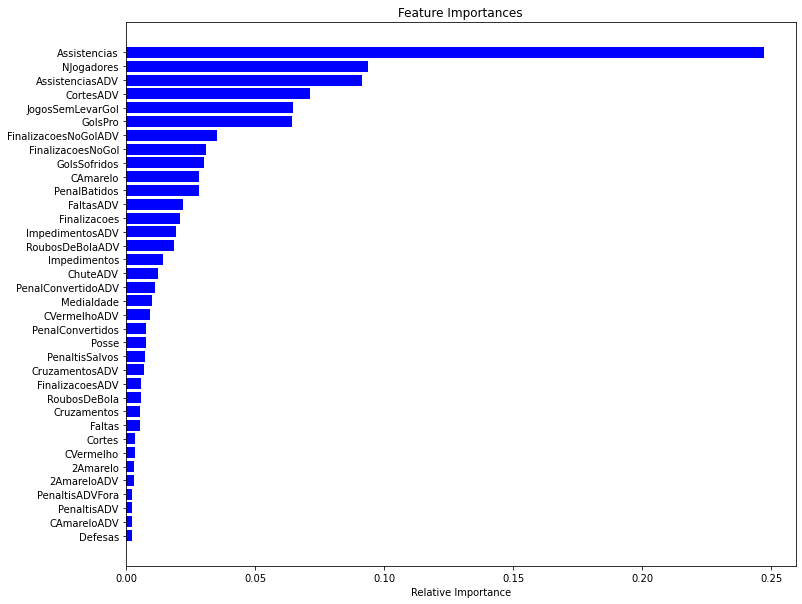

In [15]:
#Selecionar colunas de Vitória
dfV = reduzir(df191,'V',0.05)

In [16]:
#Dados e Target e teste de modelos
X = dfV.values[:,0:-1]
Y = dfV.values[:,-1]
print_models(X,Y)

LR: -0.029125 (0.636328)
LASSO: -0.570993 (0.684209)
EN: -0.562820 (0.689885)
KNN: 0.181726 (0.318217)
CART: 0.064934 (0.740950)
SVR: -0.127452 (0.416654)
RIDGE: 0.081720 (0.511964)
RIDGECV: 0.337676 (0.323616)
GPR: -0.310014 (1.124827)
AB: 0.407144 (0.325845)
RF: 0.188658 (0.307739)
ET: 0.299890 (0.492080)
GBM: 0.234890 (0.624237)
HRE: -0.778248 (1.335652)
BRI: 0.266905 (0.364628)


In [17]:
#Treinando o modelo
#V = RidgeCV().fit(X,Y)
V = BayesianRidge(n_iter = 2000).fit(X,Y)

In [18]:
#Teste do modelo
i = df20[dfV.columns]
prev = np.around(V.predict(i.values[:,0:-1]),0)

In [19]:
#Tabela de 2020 com previsão de V e V real
r = pd.DataFrame()
r['Equipe']= df20.Equipe
r['V. Prev.']= prev
r['V'] = i.V
r['Erro']=abs(r['V']-r['V. Prev.'])

r.sort_values('Erro', ascending=False)
#r.sum()  = 35  /   37 com BayesianRidge
r.sum()

Equipe      América (MG)AvaíBotafogo (SP)Brasil de Pelotas...
V. Prev.                                                  268
V                                                         273
Erro                                                       37
dtype: object

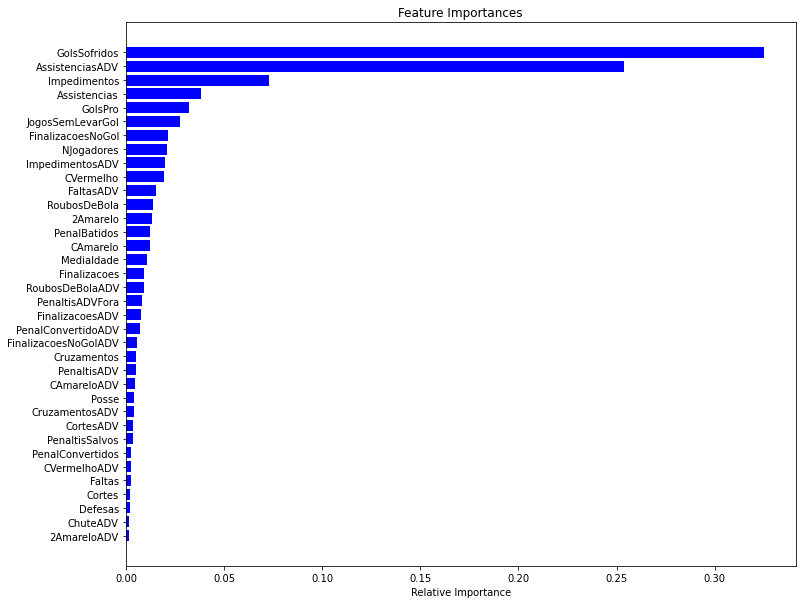

In [20]:
#Selecionar colunas de Derrotas
dfD = reduzir(df191,'D',0.05)

In [21]:
#Dados, Target e teste de modelos para Derrotas
X = dfD.values[:,0:-1]
Y = dfD.values[:,-1]
print_models(X,Y)

LR: -0.272356 (1.790088)
LASSO: -0.651893 (0.642053)
EN: -0.621293 (0.618633)
KNN: 0.557883 (0.128196)
CART: -2.310538 (4.766332)
SVR: 0.265956 (0.255604)
RIDGE: 0.299034 (0.247982)
RIDGECV: 0.449295 (0.442635)
GPR: -10.979045 (10.207853)
AB: -0.819090 (2.112899)
RF: -0.428584 (1.402107)
ET: 0.438600 (0.326106)
GBM: -0.252152 (1.165500)
HRE: -0.731466 (2.236699)
BRI: -0.052752 (1.409702)


In [22]:
#Treinando o modelo
#D = KNeighborsRegressor().fit(X,Y)
#D = RidgeCV().fit(X,Y)
D = BayesianRidge(n_iter = 2000).fit(X,Y)

In [23]:
#Teste do modelo
i = df20[dfD.columns]
prev = np.around(D.predict(i.values[:,0:-1]),0)

In [24]:
#Tabela 2020 com Derrotas Previstas e Derrotas Reais
r = pd.DataFrame()
r['Equipe']= df20.Equipe
r['D. Prev.']= prev
r['D'] = i.D
r['Erro']=abs(r['D']-r['D. Prev.'])

r.sort_values('Erro', ascending=False)
#r.sum()  = 38    /   41 com BayesianRidge
r.sum()

Equipe      América (MG)AvaíBotafogo (SP)Brasil de Pelotas...
D. Prev.                                                  246
D                                                         273
Erro                                                       41
dtype: object

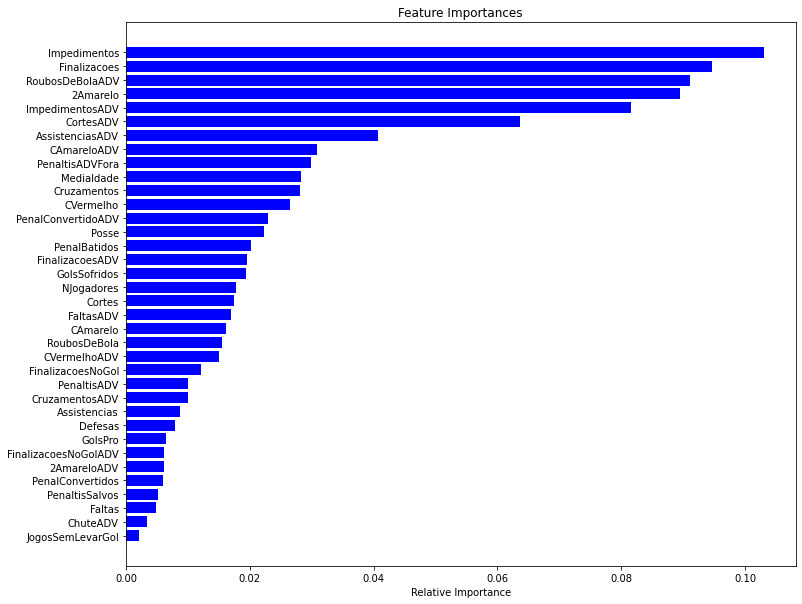

In [25]:
#Selecionando colunas de Empate
dfE = reduzir(df191,'E',0.03)

In [26]:
#Dados, Target e teste de modelos
X = dfE.values[:,0:-1]
Y = dfE.values[:,-1]
print_models(X,Y)

LR: -27.368613 (42.162137)
LASSO: -4.437946 (5.241715)
EN: -4.300995 (5.045121)
KNN: -9.624488 (15.925165)
CART: -19.918978 (36.112308)
SVR: -2.997734 (3.666726)
RIDGE: -4.214468 (6.271730)
RIDGECV: -4.292232 (6.269954)
GPR: -13.789011 (22.621705)
AB: -6.860912 (12.173540)
RF: -5.428219 (8.770613)
ET: -4.011678 (5.651398)
GBM: -10.610140 (17.419323)
HRE: -24.757168 (37.023531)
BRI: -6.080276 (9.991722)


In [27]:
#Treino do modelo
#E = RidgeCV().fit(X,Y)
E = BayesianRidge(n_iter = 2000).fit(X,Y)

In [28]:
#Teste do modelo
i = df20[dfE.columns]
prev = np.around(E.predict(i.values[:,0:-1]),0)

In [29]:
#Tabela 2020 com E previstos e E reais, e total de Erro
r = pd.DataFrame()
r['Equipes']= df20.Equipe
r['E. Prev.']= prev
r['E'] = i.E
r['Erro']=abs(r['E']-r['E. Prev.'])

r.sort_values('Erro', ascending=False)
#r.sum()  = 58   /   59 com bayesian
r.sum()

Equipes     América (MG)AvaíBotafogo (SP)Brasil de Pelotas...
E. Prev.                                                  265
E                                                         214
Erro                                                       59
dtype: object

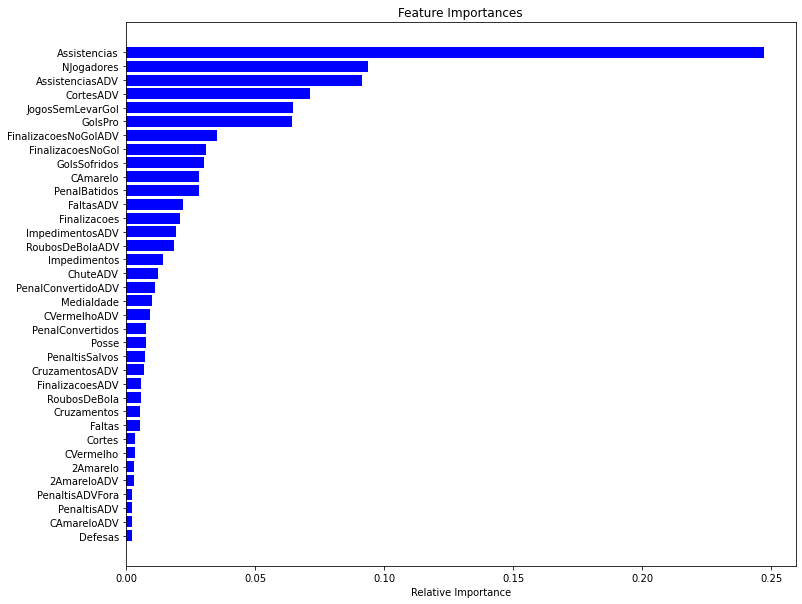

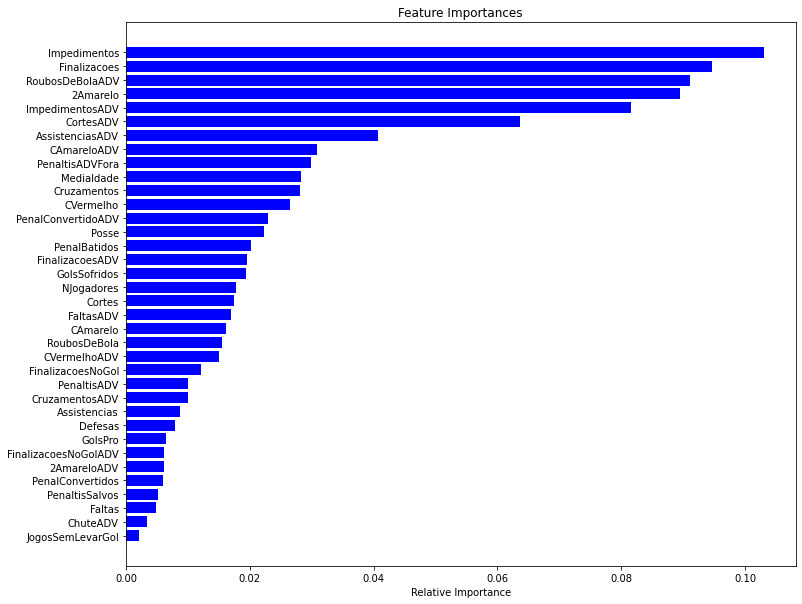

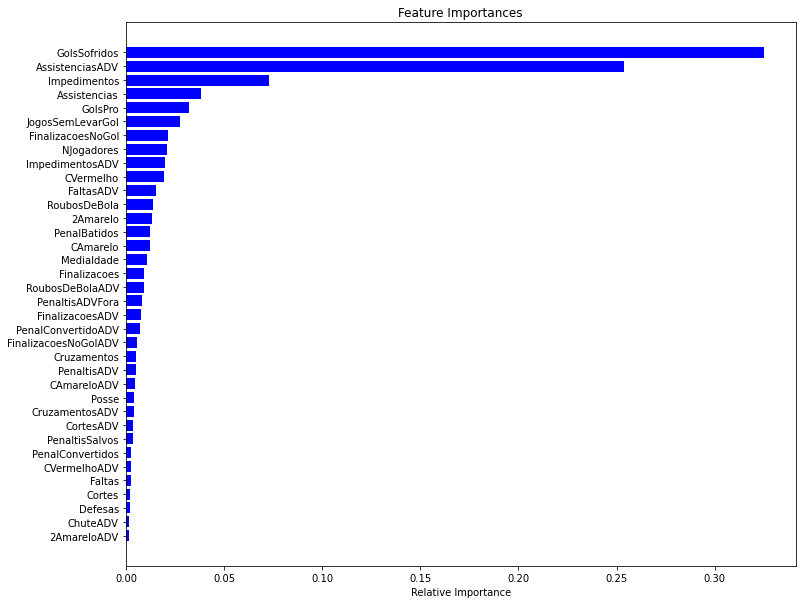

In [30]:
#Rodar todos juntos por praticidade
dfV = reduzir(df191,'V',0.05)
dfE = reduzir(df191,'E',0.03)
dfD = reduzir(df191,'D',0.05)
Xv = dfV.values[:,0:-1]
Yv = dfV.values[:,-1]
Xe = dfE.values[:,0:-1]
Ye = dfE.values[:,-1]
Xd = dfD.values[:,0:-1]
Yd = dfD.values[:,-1]

In [31]:
#Treinando os 3 modelos
V = RidgeCV().fit(Xv,Yv)
E = RidgeCV().fit(Xe,Ye)
D = RidgeCV().fit(Xd,Yd)
#V = BayesianRidge(n_iter = 2000).fit(Xv,Yv)
#E = BayesianRidge(n_iter = 2000).fit(Xe,Ye)
#D = BayesianRidge(n_iter = 2000).fit(Xd,Yd)

In [32]:
#Teste de todos os 3 modelos
v = df20[dfV.columns]
vprev = V.predict(v.values[:,0:-1])
e = df20[dfE.columns]
eprev = E.predict(e.values[:,0:-1])
d = df20[dfD.columns]
dprev = D.predict(d.values[:,0:-1])

In [33]:
#Verificando se a soma V + E + D resulta em 38 (total de rodadas)
w = pd.DataFrame()
w['Equipe'] = df20.Equipe
w['VP'] = vprev
w['EP'] = eprev
w['DP'] = dprev
w['Rodadas'] = w.VP+w.EP+w.DP
w

,Equipe,VP,EP,DP,Rodadas
0,América (MG),15.032441,15.736207,3.342045,34.110692
1,Avaí,11.865595,13.856785,17.668333,43.390713
2,Botafogo (SP),7.450561,13.186048,11.774599,32.411208
3,Brasil de Pelotas,10.870449,13.337444,7.040997,31.248889
4,CRB,14.349273,13.006947,15.283370,42.639590
5,CSA,13.327031,13.286952,11.580206,38.194189
6,Chapecoense,18.484804,14.280970,4.351278,37.117052
7,Confiança,11.408538,11.099083,16.651774,39.159395
8,Cruzeiro,14.211421,12.961127,9.946948,37.119496
9,Cuiabá,17.348928,11.750321,10.772537,39.871786


In [34]:
#Padronizando para o total de 38 rodadas
w.VP = (w.VP/w.Rodadas*38)
w.EP = (w.EP/w.Rodadas*38)
w.DP = (w.DP/w.Rodadas*38)
w['Rodadas'] = (w.VP+w.EP+w.DP)

In [35]:
w

,Equipe,VP,EP,DP,Rodadas
0,América (MG),16.746443,17.530452,3.723106,38.0
1,Avaí,10.391454,12.135265,15.473280,38.0
2,Botafogo (SP),8.735290,15.459770,13.804940,38.0
3,Brasil de Pelotas,13.218935,16.218909,8.562156,38.0
4,CRB,12.787936,11.591669,13.620395,38.0
5,CSA,13.259273,13.219398,11.521329,38.0
6,Chapecoense,18.924524,14.620689,4.454788,38.0
7,Confiança,11.070764,10.770472,16.158764,38.0
8,Cruzeiro,14.548527,13.268575,10.182898,38.0
9,Cuiabá,16.534480,11.198701,10.266819,38.0


In [36]:
#w.EP[w.soma == 37] = w.EP +1 
#w.EP[w.soma == 39] = w.EP -1 
#w['soma'] = w.VP+w.EP+w.DP

In [37]:
#Tabela 2020 com Pontos previstos e Pontos reais
w['Pt. Prev.'] = np.round(w.VP * 3 + w.EP)
w['Pts'] = df20.Pt
w['Po. Prev.']=range(1,21)
w['Erro']=abs(w['Pt. Prev.']-w['Pts'])

w.sort_values('Erro', ascending=False)
#w.sum() = 98    /  93 com Bayesian?  <- Winner
w.sum()

Equipe       América (MG)AvaíBotafogo (SP)Brasil de Pelotas...
VP                                                      259.47
EP                                                     259.789
DP                                                     240.741
Rodadas                                                    760
Pt. Prev.                                                 1039
Pts                                                       1027
Po. Prev.                                                  210
Erro                                                        98
dtype: object